In [1]:
TRAIN_ALL = False
TRAIN_BEST = True

In [2]:
from IPython.display import display, Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, balanced_accuracy_score
from sklearn.utils import class_weight

from keras import initializers, optimizers
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Dropout
from keras.models import Sequential, load_model, model_from_json
from keras.utils import plot_model, to_categorical

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np

import itertools
import keras
import time
import os

Using TensorFlow backend.


## Utilities

In [3]:
def plot_confusion_matrix(cm, class_labels, model_name, cmap=plt.cm.Blues):
    diagram_dir = os.path.join(os.getcwd(), "images")
    if not os.path.exists(diagram_dir):
        os.makedirs(diagram_dir)
    
    stats_dir = os.path.join(os.getcwd(), "stats")
    if not os.path.exists(stats_dir):
        os.makedirs(stats_dir)
    
    # create the figure
    fig = plt.figure()
    fig.set_size_inches(12,10)
    
    # labels
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    
    # tick marks
    class_count = len(class_labels)
    tick_marks = np.arange(class_count + 1)
    plt.xticks(tick_marks, class_labels, rotation=45)
    plt.yticks(tick_marks, class_labels)
    
    # normalization
    cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    cm = np.around(cm, 6)
    cm = np.nan_to_num(cm)
    
    # numbers
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:.4f}".format(cm[i, j]), horizontalalignment="center", color="white" if cm[i,j] > thresh else "black")
    
    # color bar
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.colorbar()
    
    # save and show
    np.set_printoptions(formatter={"float": lambda x: "{0:0.4f}".format(x)})
    plt.savefig(os.path.join(diagram_dir, model_name + "_confusion_matrix.png"), dpi=100)
    pd.DataFrame(cm).to_csv(os.path.join(stats_dir, model_name + "_confusion_matrix.txt"), header=None, index=None)
    plt.show(block=False)
    

def graph_history(history, model_name, validation_data=False):
    directory = os.path.join(os.getcwd(), "images")
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    # summarize history for accuracy
    fig = plt.figure()
    plt.plot(history.history["acc"], linestyle="-", color="k")
    
    if validation_data:
        plt.plot(history.history["val_acc"], linestyle="--", color="grey")
        plt.legend(["Tr. Acc", "Val. Acc"])
    
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.savefig(os.path.join(directory, model_name + "_history_accuracy.png"), dpi=400)
    plt.show()
 
    # summarize history for loss
    fig = plt.figure()
    plt.plot(history.history["loss"], linestyle="-", color="k")
    
    if validation_data:
        plt.plot(history.history["val_loss"], linestyle="--", color="grey")
        plt.legend(["Tr. Loss", "Val. Loss"])
    
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.savefig(os.path.join(directory, model_name + "_history_loss.png"), dpi=400)
    plt.show()

    
def save_model(model, model_name):
    directory = os.path.join(os.getcwd(), "models")
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    # save architecture
    with open(os.path.join(directory, model_name + ".json"), "w+") as f:
        f.write(model.to_json())
    
    # save weights
    model.save_weights(os.path.join(directory, model_name + "_weights.h5"))

def load_model(model_name):
    directory = os.path.join(os.getcwd(), "models")

    if os.path.exists(directory):
        # load the architecture
        json_file = open(os.path.join(directory, model_name + ".json"))
        model = model_from_json(json_file.read())
        model.compile(loss="categorical_crossentropy", optimizer="Adam", metrics=["accuracy"])
        json_file.close()

        # load the weights and return the model
        model.load_weights(os.path.join(directory, model_name + "_weights.h5"))
        return model

## Load data

In [4]:
# how long does this take?
start = time.time()

filename = "C:/Users/David/iCloudDrive/Documents/masters/thesis/data/snapshots/arbID_snapshots.csv"

# read the file with all dtypes
col_names = pd.read_csv(filename, nrows=0).columns
types_dict = {"Vehicle": int, "Capture": int}
types_dict.update({col: object for col in col_names if col not in types_dict})
df = pd.read_csv(filename, dtype=types_dict)

display(df.sample(frac=0.0001).head(5))
print("Elapsed time: {:.2f} seconds".format(time.time() - start))

,Vehicle,Capture,ArbID 1,ArbID 2,ArbID 3,ArbID 4,ArbID 5,ArbID 6,ArbID 7,ArbID 8,...,ArbID 119,ArbID 120,ArbID 121,ArbID 122,ArbID 123,ArbID 124,ArbID 125,ArbID 126,ArbID 127,ArbID 128
190324,4,18,48,304,122,313,342,357,369,373,...,496,522,535,331,359,389,560,602,604,640
74657,3,10,1507,372,374,384,469,458,459,505,...,458,372,374,384,469,505,533,581,534,658
258569,5,21,500,501,562,188,193,211,197,390,...,454,568,1249,2024,188,211,390,491,1257,485
195798,4,20,304,313,342,357,71,331,359,369,...,514,516,522,560,603,604,535,640,872,200
275606,7,26,1077,1084,1095,331,359,389,604,871,...,514,516,522,531,532,534,535,560,71,331


Elapsed time: 8.17 seconds


In [5]:
# relabel the vehicles
new_labels = {v: i for i, v in enumerate(df["Vehicle"].unique())}
old_labels = {i: v for i, v in enumerate(df["Vehicle"].unique())}

df["Vehicle"] = df["Vehicle"].map(new_labels)
display(df.sample(frac=0.0001).head(5))

,Vehicle,Capture,ArbID 1,ArbID 2,ArbID 3,ArbID 4,ArbID 5,ArbID 6,ArbID 7,ArbID 8,...,ArbID 119,ArbID 120,ArbID 121,ArbID 122,ArbID 123,ArbID 124,ArbID 125,ArbID 126,ArbID 127,ArbID 128
77067,2,10,640,734,853,2,372,374,384,469,...,1573,2,581,658,304,372,374,384,458,459
10952,1,3,548,32,180,186,37,36,2015,610,...,37,36,610,176,178,547,708,32,180,608
106245,2,12,901,2,734,459,372,374,384,458,...,2,533,534,768,640,458,459,734,644,372
218271,4,21,193,197,209,381,389,753,241,2015,...,479,197,491,209,501,568,647,810,2015,241
126487,2,13,374,384,469,505,581,658,304,1057,...,505,608,849,768,42,640,734,853,533,534


## Rename the arbIDs

In [6]:
# how long does this take?
start = time.time()
temp = df.copy()

for v in temp["Vehicle"].unique():
    print("Renaming arbIDs in vehicle {}".format(v))
    vehicle = df[df["Vehicle"] == v]
    arbIDs = pd.unique(vehicle.drop(columns=["Vehicle", "Capture"]).values.flatten())
    arbID_map = {a: i / (len(arbIDs) - 1) for i, a in enumerate(arbIDs)}
    df.loc[df["Vehicle"] == v] = df.loc[df["Vehicle"] == v].replace(arbID_map)

display(df.head(5))
print("Elapsed time: {:.2f} seconds".format(time.time() - start))

Renaming arbIDs in vehicle 0
Renaming arbIDs in vehicle 1
Renaming arbIDs in vehicle 2
Renaming arbIDs in vehicle 3
Renaming arbIDs in vehicle 4
Renaming arbIDs in vehicle 5
Renaming arbIDs in vehicle 6
Renaming arbIDs in vehicle 7
Renaming arbIDs in vehicle 8
Renaming arbIDs in vehicle 9
Renaming arbIDs in vehicle 10
Renaming arbIDs in vehicle 11
Renaming arbIDs in vehicle 12
Renaming arbIDs in vehicle 13
Renaming arbIDs in vehicle 14
Renaming arbIDs in vehicle 15
Renaming arbIDs in vehicle 16
Renaming arbIDs in vehicle 17
Renaming arbIDs in vehicle 18
Renaming arbIDs in vehicle 19


,Vehicle,Capture,ArbID 1,ArbID 2,ArbID 3,ArbID 4,ArbID 5,ArbID 6,ArbID 7,ArbID 8,...,ArbID 119,ArbID 120,ArbID 121,ArbID 122,ArbID 123,ArbID 124,ArbID 125,ArbID 126,ArbID 127,ArbID 128
0,0,1,0,0.142857,0.285714,0.142857,0.428571,0,0.285714,0.142857,...,0,0.285714,0.142857,0.428571,0,0.142857,0.285714,0.714286,0.428571,0
1,0,1,0.142857,0.285714,0.428571,0.142857,0,0.285714,0.142857,0.428571,...,0.428571,0.142857,0,0.285714,0.142857,0.428571,0,0.714286,0.142857,0.285714
2,0,1,0.428571,0,0.142857,0.571429,0.285714,0.428571,0.142857,0,...,0,0.142857,0.285714,0.428571,0.142857,0,0.285714,0.142857,0.428571,0
3,0,1,0.714286,0.142857,0.285714,0.428571,0,0.142857,0.285714,0.428571,...,0.285714,0.428571,0,0.142857,0.571429,0.285714,0.428571,0.142857,0,0.285714
4,0,1,0.142857,0.714286,0.428571,0,0.142857,0.285714,0.428571,0,...,0.428571,0,0.142857,0.285714,0.428571,0.142857,0,0.285714,0.142857,0.428571


Elapsed time: 406.34 seconds


## Separate the data

In [7]:
"""
All vehicles
"""

# split into (x, y) sets
all_df_x = df.drop(columns=["Vehicle", "Capture"])
all_df_y = df["Vehicle"]

# split vehicles into train/validation/test (60/20/20)
all_nontest_x, all_test_x, all_nontest_y, all_test_y = train_test_split(all_df_x, all_df_y, test_size=0.2)
all_train_x, all_val_x, all_train_y, all_val_y = train_test_split(all_nontest_x, all_nontest_y, test_size=0.25)

# scale the inputs
all_train_x /= 255.
all_val_x /= 255.
all_test_x /= 255.

# encode the labels as one-hot variables
all_train_y = keras.utils.to_categorical(all_train_y, 20)
all_val_y = keras.utils.to_categorical(all_val_y, 20)
all_test_y = keras.utils.to_categorical(all_test_y, 20)

# sanity check
print("Train      : {} {}".format(all_train_x.shape, all_train_y.shape))
print("Validation : {} {}".format(all_val_x.shape, all_val_y.shape))
print("Test       : {} {}".format(all_test_x.shape, all_test_y.shape))

Train      : (210422, 128) (210422, 20)
Validation : (70141, 128) (70141, 20)
Test       : (70141, 128) (70141, 20)


In [8]:
"""
All vehicles balanced
"""

# balance the dataset
min_size = np.min([len(df[df["Vehicle"] == i]) for i in df["Vehicle"].unique()])
balanced_df = df.groupby("Vehicle", group_keys=False).apply(pd.DataFrame.sample, n=min_size)

# split into (x, y) sets
balanced_df_x = balanced_df.drop(columns=["Vehicle", "Capture"])
balanced_df_y = balanced_df["Vehicle"]

# split vehicles into train/validation/test (60/20/20)
balanced_nontest_x, balanced_test_x, balanced_nontest_y, balanced_test_y = train_test_split(balanced_df_x, balanced_df_y, test_size=0.2)
balanced_train_x, balanced_val_x, balanced_train_y, balanced_val_y = train_test_split(balanced_nontest_x, balanced_nontest_y, test_size=0.25)

# scale the inputs
balanced_train_x /= 255.
balanced_val_x /= 255.
balanced_test_x /= 255.

# encode the labels as one-hot variables
balanced_train_y = keras.utils.to_categorical(balanced_train_y, 20)
balanced_val_y = keras.utils.to_categorical(balanced_val_y, 20)
balanced_test_y = keras.utils.to_categorical(balanced_test_y, 20)

# sanity check
print("Train      : {} {}".format(balanced_train_x.shape, balanced_train_y.shape))
print("Validation : {} {}".format(balanced_val_x.shape, balanced_val_y.shape))
print("Test       : {} {}".format(balanced_test_x.shape, balanced_test_y.shape))

Train      : (23232, 128) (23232, 20)
Validation : (7744, 128) (7744, 20)
Test       : (7744, 128) (7744, 20)


In [9]:
"""
Stone's vehicles
"""

# split into (x, y) sets
stone = df[df["Vehicle"] >= 9]
stone_x = stone.drop(columns=["Vehicle", "Capture"])
stone_y = stone["Vehicle"] - 9

# split vehicles into train/validation/test (60/20/20)
stone_nontest_x, stone_test_x, stone_nontest_y, stone_test_y = train_test_split(stone_x, stone_y, test_size=0.2)
stone_train_x, stone_val_x, stone_train_y, stone_val_y = train_test_split(stone_nontest_x, stone_nontest_y, test_size=0.25)

# scale the inputs
stone_train_x /= 255.
stone_val_x /= 255.
stone_test_x /= 255.

# encode the labels as one-hot variables
stone_train_y = keras.utils.to_categorical(stone_train_y, 11)
stone_val_y = keras.utils.to_categorical(stone_val_y, 11)
stone_test_y = keras.utils.to_categorical(stone_test_y, 11)

# sanity check
print("Train      : {} {}".format(stone_train_x.shape, stone_train_y.shape))
print("Validation : {} {}".format(stone_val_x.shape, stone_val_y.shape))
print("Test       : {} {}".format(stone_test_x.shape, stone_test_y.shape))

Train      : (19504, 128) (19504, 11)
Validation : (6502, 128) (6502, 11)
Test       : (6502, 128) (6502, 11)


In [10]:
"""
Stone's vehicles balanced
"""

# balance the dataset
stone_min_size = np.min([len(stone[stone["Vehicle"] == i]) for i in stone["Vehicle"].unique()])
stone_balanced_df = stone.groupby("Vehicle", group_keys=False).apply(pd.DataFrame.sample, n=stone_min_size)

# split into (x, y) sets
stone_balanced_df_x = balanced_df.drop(columns=["Vehicle", "Capture"])
stone_balanced_df_y = balanced_df["Vehicle"] - 9

# split vehicles into train/validation/test (60/20/20)
stone_balanced_nontest_x, stone_balanced_test_x, stone_balanced_nontest_y, stone_balanced_test_y \
    = train_test_split(stone_balanced_df_x, stone_balanced_df_y, test_size=0.2)
stone_balanced_train_x, stone_balanced_val_x, stone_balanced_train_y, stone_balanced_val_y \
    = train_test_split(stone_balanced_nontest_x, stone_balanced_nontest_y, test_size=0.25)

# scale the inputs
stone_balanced_train_x /= 255.
stone_balanced_val_x /= 255.
stone_balanced_test_x /= 255.

# encode the labels as one-hot variables
stone_balanced_train_y = keras.utils.to_categorical(stone_balanced_train_y, 11)
stone_balanced_val_y = keras.utils.to_categorical(stone_balanced_val_y, 11)
stone_balanced_test_y = keras.utils.to_categorical(stone_balanced_test_y, 11)

# sanity check
print("Train      : {} {}".format(stone_balanced_train_x.shape, stone_balanced_train_y.shape))
print("Validation : {} {}".format(stone_balanced_val_x.shape, stone_balanced_val_y.shape))
print("Test       : {} {}".format(stone_balanced_test_x.shape, stone_balanced_test_y.shape))

Train      : (23232, 128) (23232, 11)
Validation : (7744, 128) (7744, 11)
Test       : (7744, 128) (7744, 11)


## Build the models

In [11]:
def build_model(hidden_layers, hidden_layer_width, activation, learning_rate, filename):
    directory = os.path.join(os.getcwd(), "images")
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    model = Sequential()
    
    # build the first hidden layer
    model.add(Dense(
        units = hidden_layer_width,
        input_dim = 128,
        activation = activation,
        use_bias = True,
        bias_initializer = initializers.Constant(0.1) if activation == "relu" else "zeros"))
    
    # build the remaining hidden layers
    for i in range(hidden_layers - 1):
        model.add(Dense(
            units = hidden_layer_width, 
            activation = activation, 
            use_bias = True, 
            bias_initializer = initializers.Constant(0.1) if activation == "relu" else "zeros"))
    
    # add some regularization
    model.add(Dropout(0.2))
    
    # build the output layer
    model.add(Dense(
        units = 11, 
        activation = "softmax", 
        use_bias = True, 
        bias_initializer = "zeros"))
    
    # compile the model
    model.compile(
        optimizer = optimizers.Adam(lr=learning_rate),
        loss = "categorical_crossentropy",
        metrics = ["accuracy"])

    # display and return the model
    print(model.summary())
    filename = os.path.join(directory, filename + "_diagram.png")
    plot_model(model, show_shapes=True, show_layer_names=True, to_file=filename)
    display(Image(filename=filename, width=400))
    
    return model

In [12]:
# model configurations
num_hidden_layers = [1, 2, 3]
hidden_layer_widths = [128, 256, 512]
activation_functions = ["relu"]
learning_rates = [0.01, 0.001, 0.0001]

## Train and test all models

In [13]:
if TRAIN_ALL:
    # how long does this take?
    start_time = time.time()
    
    # we'll need these
    train_x = stone_train_x
    train_y = stone_train_y
    val_x = stone_val_x
    val_y = stone_val_y
    test_x = stone_test_x
    test_y = stone_test_y

    # gather training stats
    stats_dir = os.path.join(os.getcwd(), "stats")
    if not os.path.exists(stats_dir):
        os.makedirs(stats_dir)

    stats_path = os.path.join(stats_dir, "training_stats.csv")
    stats_file = open(stats_path, "w+")
    stats_file.write(
        "Model,Parameters,Training Epoch,Training Loss,Training Accuracy,Test Loss,Test Accuracy,Balanced Test Accuracy\n")

    # gather model stats
    models_dir = os.path.join(os.getcwd(), "models")
    if not os.path.exists(models_dir):
        os.makedirs(models_dir)

    models_path = os.path.join(models_dir, "models.csv")
    models_file = open(models_path, "w+")
    models_file.write("Model,Num Layers,Layer Sizes,Activation,Learning Rate\n")

    # stop early if possible
    callbacks = [EarlyStopping(
        monitor = "val_loss",
        patience = 10,
        restore_best_weights = True
    )]

    # this'll take a while
    count = 0
    for n in num_hidden_layers:
        for w in hidden_layer_widths:
            for a in activation_functions:
                for l in learning_rates:
                    print("{}\n{} Model {}: num layers = {}, layer size = {}, activation = {}, learning rate = {}\n{}".format(
                        "=" * 100, "=" * 5, count, n, w, a, l, "=" * 100))

                    # filepaths
                    model_name = "model_{}".format(count)

                    # build and show model
                    model = build_model(n, w, a, l, model_name)

                    # we'll need these
                    y_ints = [y.argmax() for y in train_y]
                    class_weights = class_weight.compute_class_weight("balanced", np.unique(y_ints), y_ints)

                    # train model
                    history = model.fit(
                        train_x, train_y,
                        validation_data = (val_x, val_y),
                        class_weight = class_weights,
                        batch_size = 512,
                        epochs = 200,
                        shuffle = True,
                        verbose = 1,
                        callbacks = callbacks)

                    # save trained model
                    # save_model(model, model_name)

                    # show the graph history
                    graph_history(history, model_name, validation_data=True)

                    # evaluate the model
                    evaluation = model.evaluate(test_x, test_y, verbose=0)

                    print("--- Test set evaluation ---")
                    print("Loss              : {:.4f}".format(evaluation[0]))
                    print("Accuracy          : {:.4f}".format(evaluation[1]))

                    # predict the test set and save the labels
                    actual_labels = np.argmax(test_y, axis=1)
                    predicted_labels = np.argmax(model.predict(test_x), axis=1)
                    balanced_acc = balanced_accuracy_score(actual_labels, predicted_labels)

                    print("Balanced accuracy : {:.4f}".format(balanced_acc))

                    # revert to the original vehicle IDs
                    actual_labels = [old_labels[i] for i in actual_labels]
                    predicted_labels = [old_labels[i] for i in predicted_labels]

                    # generate, save, and display confusion matrix
                    cm = confusion_matrix(predicted_labels, actual_labels)
                    plot_confusion_matrix(cm, class_labels=old_labels.values(), model_name=model_name)

                    # get stats
                    params = model.count_params()
                    best_epoch = np.argmin(history.history["val_loss"])
                    best_loss = history.history["val_loss"][best_epoch]
                    best_acc = history.history["val_acc"][best_epoch]

                    # save stats
                    stats = [count, params, best_epoch, best_loss, best_acc, evaluation[0], evaluation[1], balanced_acc]
                    stats_file.write(",".join([str(s) for s in stats]) + "\n")

                    # save model metadata
                    model_metadata = [count, n, w, a, l]
                    models_file.write(",".join([str(d) for d in model_metadata]) + "\n")

                    # next model
                    count += 1

    stats_file.close()
    models_file.close()

    elapsed_time = time.time() - start_time
    print("Elapsed time: {:.2f} seconds ({:.2f} hours)".format(elapsed_time, elapsed_time / 3600.))

## Train and test the best model

W0923 11:24:00.786500 13160 deprecation_wrapper.py:119] From C:\Anaconda3\envs\dl\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



Model              24
Num Layers          3
Layer Sizes       512
Activation       relu
Learning Rate    0.01
Name: 24, dtype: object


W0923 11:24:01.023579 13160 deprecation_wrapper.py:119] From C:\Anaconda3\envs\dl\lib\site-packages\keras\backend\tensorflow_backend.py:519: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0923 11:24:01.109346 13160 deprecation_wrapper.py:119] From C:\Anaconda3\envs\dl\lib\site-packages\keras\backend\tensorflow_backend.py:4140: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0923 11:24:01.315014 13160 deprecation_wrapper.py:119] From C:\Anaconda3\envs\dl\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0923 11:24:01.358976 13160 deprecation.py:506] From C:\Anaconda3\envs\dl\lib\site-packages\keras\backend\tensorflow_backend.py:3447: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               66048     
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 11)                5643      
Total params: 597,003
Trainable params: 597,003
Non-trainable params: 0
_________________________________________________________________
None


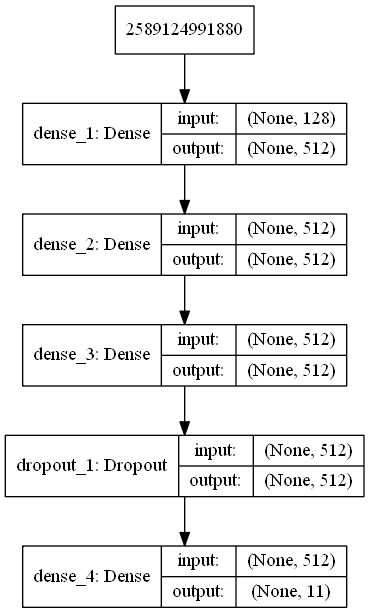

W0923 11:24:02.383786 13160 deprecation.py:323] From C:\Anaconda3\envs\dl\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/64
30976/30976 [==============================] - 16s 519us/step - loss: 2.3483 - acc: 0.1754
Epoch 2/64
30976/30976 [==============================] - 7s 230us/step - loss: 1.5070 - acc: 0.3863
Epoch 3/64
30976/30976 [==============================] - 7s 238us/step - loss: 1.2385 - acc: 0.5061
Epoch 4/64
30976/30976 [==============================] - 7s 223us/step - loss: 1.1477 - acc: 0.5539
Epoch 5/64
30976/30976 [==============================] - 7s 222us/step - loss: 1.1646 - acc: 0.5416
Epoch 6/64
30976/30976 [==============================] - 7s 228us/step - loss: 1.1630 - acc: 0.5480
Epoch 7/64
30976/30976 [==============================] - 7s 217us/step - loss: 1.0772 - acc: 0.5839
Epoch 8/64
30976/30976 [==============================] - 7s 220us/step - loss: 1.0669 - acc: 0.5877
Epoch 9/64
30976/30976 [==============================] - 7s 220us/step - loss: 1.0798 - acc: 0.5808
Epoch 10/64
30976/30976 [==============================] - 7s 226us/step - loss: 1.1597 - 

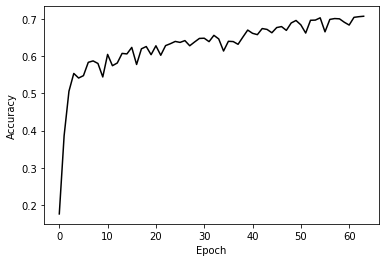

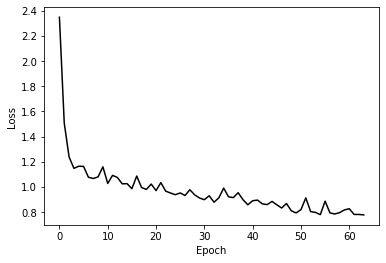

--- Test set evaluation ---
Loss              : 0.8155
Accuracy          : 0.6921
Balanced accuracy : 0.6816


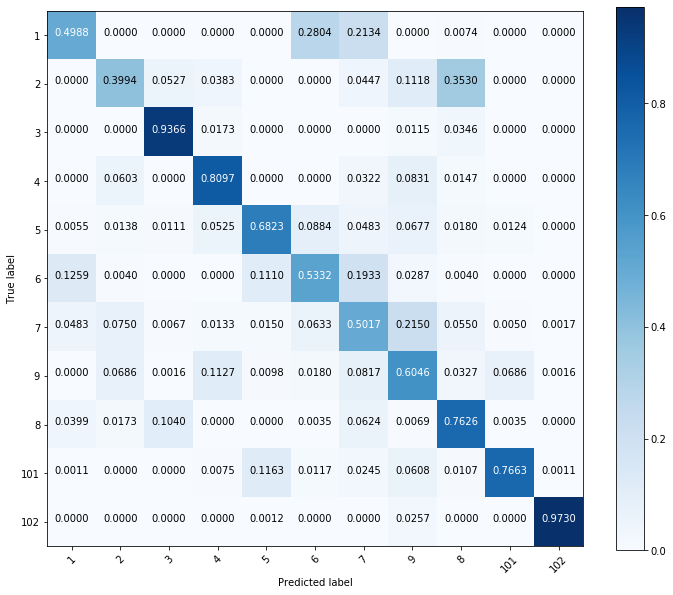

In [14]:
if TRAIN_BEST:
#     for dataset in ["all", "balanced"]:
#     for dataset in ["all"]:
    for dataset in ["balanced"]:
        # best model
        training_stats = pd.read_csv(os.path.join(os.getcwd(), "stats", "training_stats.csv"))
        best_model = int(training_stats.sort_values(by=["Training Loss"]).iloc[0]["Model"])
        best_epoch = int(training_stats.sort_values(by=["Training Loss"]).iloc[0]["Training Epoch"])
        
        # model parameters
        model_params = pd.read_csv(os.path.join(os.getcwd(), "models", "models.csv"))
        best_model = model_params.iloc[best_model]
        print(best_model)

        # filepaths
        model_name = "final_model_all" if dataset == "all" else "final_model_balanced"

        # build and show model
        model = build_model(best_model["Num Layers"], best_model["Layer Sizes"],
            best_model["Activation"], best_model["Learning Rate"], model_name)

        # we'll need these
        train_x = stone_train_x if dataset == "all" else stone_balanced_train_x
        train_y = stone_train_y if dataset == "all" else stone_balanced_train_y
        val_x = stone_val_x if dataset == "all" else stone_balanced_val_x
        val_y = stone_val_y if dataset == "all" else stone_balanced_val_y
        test_x = stone_test_x if dataset == "all" else stone_balanced_test_x
        test_y = stone_test_y if dataset == "all" else stone_balanced_test_y

        # and these
        y_ints = [y.argmax() for y in train_y]
        class_weights = class_weight.compute_class_weight("balanced", np.unique(y_ints), y_ints)
        class_weights = class_weights if dataset == "all" else None

        # train model
        history = model.fit(
            np.concatenate((train_x, val_x)), np.concatenate((train_y, val_y)),
            class_weight = class_weights,
            batch_size = 512,
            epochs = best_epoch,
            shuffle = True,
            verbose = 1)

        # save trained model
        save_model(model, model_name)

        # show the graph history
        graph_history(history, model_name)

        # evaluate the model
        evaluation = model.evaluate(test_x, test_y, verbose=0)

        print("--- Test set evaluation ---")
        print("Loss              : {:.4f}".format(evaluation[0]))
        print("Accuracy          : {:.4f}".format(evaluation[1]))

        # predict the test set and save the labels
        actual_labels = np.argmax(test_y, axis=1)
        predicted_labels = np.argmax(model.predict(test_x), axis=1)

        print("Balanced accuracy : {:.4f}".format(balanced_accuracy_score(actual_labels, predicted_labels)))

        # revert to the original vehicle IDs
        actual_labels = [old_labels[i] for i in actual_labels]
        predicted_labels = [old_labels[i] for i in predicted_labels]

        # generate, save, and display confusion matrix
        cm = confusion_matrix(predicted_labels, actual_labels)
        plot_confusion_matrix(cm, class_labels=old_labels.values(), model_name=model_name)

## Load and test the best model

--- Test set evaluation all ---
Loss              : 0.4127
Accuracy          : 0.8507
Balanced accuracy : 0.8208


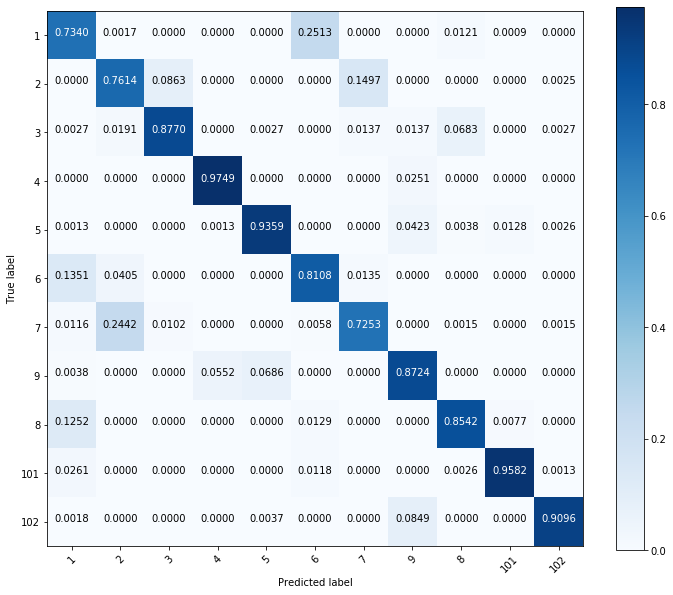

--- Test set evaluation balanced ---
Loss              : 0.8155
Accuracy          : 0.6921
Balanced accuracy : 0.6816


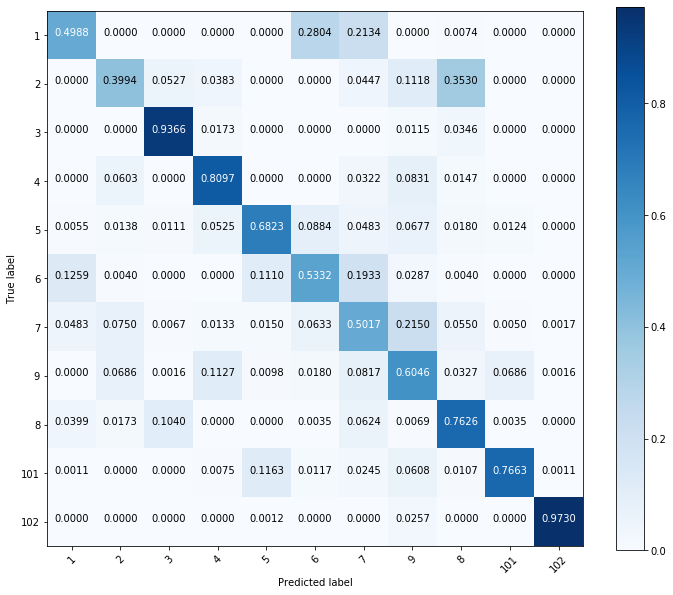

In [15]:
if TRAIN_BEST:
    for dataset in ["all", "balanced"]:
        # we'll need these
        test_x = stone_test_x if dataset == "all" else stone_balanced_test_x
        test_y = stone_test_y if dataset == "all" else stone_balanced_test_y

        # name the model
        model_name = "final_model_all" if dataset == "all" else "final_model_balanced"
        model = load_model(model_name)

        # evaluate the model
        evaluation = model.evaluate(test_x, test_y, verbose=0)

        print("--- Test set evaluation {} ---".format(dataset))
        print("Loss              : {:.4f}".format(evaluation[0]))
        print("Accuracy          : {:.4f}".format(evaluation[1]))

        # predict the test set and save the labels
        actual_labels = np.argmax(test_y, axis=1)
        predicted_labels = np.argmax(model.predict(test_x), axis=1)

        print("Balanced accuracy : {:.4f}".format(balanced_accuracy_score(actual_labels, predicted_labels)))

        # revert to the original vehicle IDs
        actual_labels = [old_labels[i] for i in actual_labels]
        predicted_labels = [old_labels[i] for i in predicted_labels]

        # generate, save, and display confusion matrix
        cm = confusion_matrix(predicted_labels, actual_labels)
        plot_confusion_matrix(cm, class_labels=old_labels.values(), model_name=model_name)